In [389]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap
from shap import plots

import pickle

import pathlib
from glob import glob
from data_loader import get_pdf_filepaths

In [285]:
def get_agg_dfs_filepaths(folder_path):
    absolute_folder_path = pathlib.Path(folder_path).resolve()
    #print(absolute_folder_path)
    pattern = str(absolute_folder_path / '**/aggregated.csv')
    #print(pattern)
    return glob(pattern)

In [286]:
def get_agg_dfs_filepaths_philosophy(folder_path):
    absolute_folder_path = pathlib.Path(folder_path).resolve()
    #print(absolute_folder_path)
    pattern = str(absolute_folder_path / 'philosophy/**/aggregated.csv')
    #print(pattern)
    return glob(pattern)

# 0. Create dataset from the csvs of all books

In [287]:
DATA_DIR_PATH = "../data/"
PDF_SOURCE_DIR_PATH = DATA_DIR_PATH + "pdf/"
PROCESSED_DATA_DIR_PATH = DATA_DIR_PATH + "processed/"

In [288]:
file_paths = get_agg_dfs_filepaths(PROCESSED_DATA_DIR_PATH)
file_paths

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2015_Book_LinearAlgebra/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2007BoolosComputability and Logic Fifth Edition/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2014_Book_Microeconomics/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/jacobson_14/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/moltmann_97/ag

In [289]:
file_paths_philo = get_agg_dfs_filepaths_philosophy(PROCESSED_DATA_DIR_PATH)
file_paths_philo

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/peregrin_17/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/shapiro_97/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/linnebo_18/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/jenkins_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/

In [290]:
list_agg_dfs=[]
for path in file_paths:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df = pd.concat(list_agg_dfs)

In [291]:
list_agg_dfs=[]
for path in file_paths_philo:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df_s = pd.concat(list_agg_dfs)

In [292]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372652 entries, 0 to 46618
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    372650 non-null  object 
 1   length               372652 non-null  int64  
 2   is_named_entity      372652 non-null  int64  
 3   is_named_author      372652 non-null  int64  
 4   is_in_toc            372652 non-null  int64  
 5   freq                 372652 non-null  float64
 6   is_in_index          372652 non-null  int64  
 7   tfidf                372652 non-null  float64
 8   importance           372652 non-null  float64
 9   position_in_context  372652 non-null  float64
 10  POS                  372652 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 34.1+ MB


# 1. Feature engineering

In [293]:
df.reset_index(drop=True, inplace=True)

In [294]:
df_s.reset_index(drop=True, inplace=True)

In [295]:
df.groupby('POS').count()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context
POS,,,,,,,,,,
ADJ,19629,19637,19637,19637,19637,19637,19637,19637,19637,19637
ADP,769,769,769,769,769,769,769,769,769,769
ADV,7305,7305,7305,7305,7305,7305,7305,7305,7305,7305
AUX,282,282,282,282,282,282,282,282,282,282
CCONJ,98,98,98,98,98,98,98,98,98,98
CHUNK,749051,749051,749051,749051,749051,749051,749051,749051,749051,749051
DET,167,167,167,167,167,167,167,167,167,167
INTJ,251,251,251,251,251,251,251,251,251,251
NOUN,43999,43999,43999,43999,43999,43999,43999,43999,43999,43999


In [296]:
df.dropna(inplace=True)

In [297]:
df_s.dropna(inplace=True)

In [298]:
textbook_words=['whereas', 
                'conversely', 
                'result',
                'suggest',
                'contrast', 
                'comparison', 
                'view', 
                'likewise',
                'despite',
                'while',
                'subsequent',
                'subsequently',
                'overall',
                'summary',
                'sumarize',
                'first',
                'second', 
                'third',
                'firstly',
                'secondly', 
                'thirdly',
                'finally',
                'although',
                'thus',
                'again',
                'further',
                'then',
                'besides',
                'too',
                'similarly',
                'correspondingly',
                'regarding',
                'involved',
                'approach',
                'account',
                'theory',
                'method',
                'required',
                'process',
                'research',
                'role',
                'significant',
                'source',
                'variable',
                'issue',
                'function',
                'formula',
                'formulate',
                'phrase',
                'factor',
                'evidence',
                'derived',
                'derive',
                'establish',
                'concept',
                'available',
                'context',
                'assume',
                'assumption',
                'additionally',
                'additional',
                'analysis',
                'general',
                'certain',
                'certainly',
                'furthermore',
                'moreover',
                'nonetheless',
                'nevertheless',
                'bibliography',
                'prove',
                'part',
                'today', 
                'nowadays', 
                'actually', 
                'section', 
                'indeed', 
                'every', 
                'any', 
                'some',
                'instance',
                'example', 
                'therefore', 
                'definition',
                'define',
                'explain',
                'explanation',
                'introduction', 
                'conclusion',
                'conclude',
                'chapter', 
                'appendix', 
                'otherwise', 
                'thing',
                'concisely',
                'concise',
                'brief',
                'briefly',
                'rather', 
                'instead', 
                'like', 
                'since', 
                'given', 
                'case', 
                'hence', 
                'iff', 
                'see', 
                'beyond', 
                'below', 
                'above', 
                'postscript',
                'preface',
                'index', 
                'ensure', 
                'generally', 
                'anything', 
                'something',
                'everything',
                'other']

In [299]:
dict_tbw={}
for w in df.candidate_keyword:
    if w in textbook_words:
        dict_tbw[w]=1
    else:
        dict_tbw[w]=0

In [300]:
dict_tbw_s={}
for w in df_s.candidate_keyword:
    if w in textbook_words:
        dict_tbw_s[w]=1
    else:
        dict_tbw_s[w]=0

In [301]:
def is_a_tbw(x):
    if w in textbook_words:
        return 1
    else: 
        return 0

In [302]:
df['is_a_textbook_word']=df.candidate_keyword.apply(lambda x: dict_tbw[x])

In [303]:
df_s['is_a_textbook_word']=df_s.candidate_keyword.apply(lambda x: dict_tbw_s[x])

In [304]:
df_scaled = pd.get_dummies(df, columns=['POS'],
prefix = ['POS'])

In [305]:
df_s_scaled = pd.get_dummies(df_s, columns=['POS'],
prefix = ['POS'])

In [306]:
df_s_scaled.head()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context,...,POS_NOUN,POS_NUM,POS_PART,POS_PRON,POS_PROPN,POS_PUNCT,POS_SCONJ,POS_SYM,POS_VERB,POS_X
0,a-laying,8,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,1,0,0,0,0,0,0,0,0,0
1,a-laying police,15,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,0,0,0,0,0,0,0,0,0,0
2,aardvark,8,0,0,0,0.000013,0,0.000000,0.644323,1.000000,...,1,0,0,0,0,0,0,0,0,0
3,abandoned,9,0,0,0,0.000038,0,0.009811,0.449342,0.611827,...,0,0,0,0,0,0,0,0,1,0
4,abandoned commitment,20,0,0,0,0.000013,0,0.000000,0.392002,0.272727,...,0,0,0,0,0,0,0,0,0,0


In [307]:
df_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [308]:
df_s_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [309]:
df_scaled_columns = df_scaled.columns

In [310]:
df_s_scaled_columns = df_s_scaled.columns

In [311]:
scaler = MinMaxScaler() 

In [312]:
#not sure about this (do I need to concat or what?)
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns= df_scaled_columns)#not sure about this (do I need to concat or what?)

In [313]:
df_s_scaled = scaler.fit_transform(df_s_scaled)
df_s_scaled = pd.DataFrame(df_s_scaled, columns= df_s_scaled_columns)

In [314]:
df_scaled=df_scaled.rename(columns={"is_in_index": "target"})

In [315]:
df_s_scaled=df_s_scaled.rename(columns={"is_in_index": "target"})

In [320]:
df_s_scaled_1=df_s_scaled.drop(columns=['POS_SYM', 
                                        'POS_PART', 
                                        'POS_PUNCT', 
                                        'POS_INTJ', 
                                        'POS_DET',
                                        'POS_AUX',
                                        'POS_SCONJ',
                                        'POS_CCONJ',
                                        'POS_X',
                                        'POS_PRON',
                                        'POS_ADP',
                                        'POS_NUM'], errors='ignore')
df_scaled_1=df_scaled.drop(columns=['POS_SYM', 
                                        'POS_PART', 
                                        'POS_PUNCT', 
                                        'POS_INTJ', 
                                        'POS_DET',
                                        'POS_AUX',
                                        'POS_SCONJ',
                                        'POS_CCONJ',
                                        'POS_X',
                                        'POS_PRON',
                                        'POS_ADP',
                                        'POS_NUM'], errors='ignore)

In [322]:
df_scaled_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856871 entries, 0 to 856870
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  float64
 1   is_named_entity      856871 non-null  float64
 2   is_named_author      856871 non-null  float64
 3   is_in_toc            856871 non-null  float64
 4   freq                 856871 non-null  float64
 5   target               856871 non-null  float64
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   is_a_textbook_word   856871 non-null  float64
 10  POS_ADJ              856871 non-null  float64
 11  POS_ADV              856871 non-null  float64
 12  POS_CHUNK            856871 non-null  float64
 13  POS_NOUN             856871 non-null  float64
 14  POS_PROPN            856871 non-null  float64
 15  POS_VERB         

In [ ]:
df_scaled.to_csv("../data/final_scaled.csv", encoding = 'utf-8')

In [321]:
df_scaled_1.to_csv("../data/final_scaled_1.csv", encoding = 'utf-8')

In [ ]:
df_s_scaled.to_csv("../data/final_scaled_small.csv", encoding = 'utf-8')

In [323]:
df_s_scaled_1.to_csv("../data/final_scaled_small_1.csv", encoding = 'utf-8')

# 2. Quick EDA

In [2]:
path = '../data/final_scaled.csv'
df_scaled = pd.read_csv(path,index_col=0)
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856871 entries, 0 to 856870
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  float64
 1   is_named_entity      856871 non-null  float64
 2   is_named_author      856871 non-null  float64
 3   is_in_toc            856871 non-null  float64
 4   freq                 856871 non-null  float64
 5   target               856871 non-null  float64
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   is_a_textbook_word   856871 non-null  float64
 10  POS_ADJ              856871 non-null  float64
 11  POS_ADP              856871 non-null  float64
 12  POS_ADV              856871 non-null  float64
 13  POS_AUX              856871 non-null  float64
 14  POS_CCONJ            856871 non-null  float64
 15  POS_CHUNK        

In [3]:
path = '../data/final_scaled_small.csv'
df_s_scaled = pd.read_csv(path,index_col=0)
df_s_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372650 entries, 0 to 372649
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               372650 non-null  float64
 1   is_named_entity      372650 non-null  float64
 2   is_named_author      372650 non-null  float64
 3   is_in_toc            372650 non-null  float64
 4   freq                 372650 non-null  float64
 5   target               372650 non-null  float64
 6   tfidf                372650 non-null  float64
 7   importance           372650 non-null  float64
 8   position_in_context  372650 non-null  float64
 9   is_a_textbook_word   372650 non-null  float64
 10  POS_ADJ              372650 non-null  float64
 11  POS_ADP              372650 non-null  float64
 12  POS_ADV              372650 non-null  float64
 13  POS_AUX              372650 non-null  float64
 14  POS_CCONJ            372650 non-null  float64
 15  POS_CHUNK        

### Pairplot all columns

In [ ]:
g = sns.pairplot(df_scaled, y_vars= df_scaled.columns.values, x_vars="target")
g.fig.set_size_inches(7,14)

In [ ]:
pairplot=sns.pairplot(df_scaled, hue='target')

In [ ]:
pairplot

In [ ]:
pairplot.figure.savefig("..images/images/pairplot.png")

### Correlation heatmap

In [ ]:
plt.figure(figsize=(4, 10))

heatmap = sns.heatmap(df_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [ ]:
heatmap.figure.savefig("../images/heatmap.png", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(4, 10))

heatmap_s = sns.heatmap(df_s_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap_s.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [ ]:
heatmap_s.figure.savefig("../images/heatmap_s.png", bbox_inches="tight")

### Types of books

In [164]:
types_books={'Philosophy': 10, 'Linguistics': 6,  'Logic': 2, 'Economics': 1,  'Data Science': 1, 'Maths': 1, 'Astronomy': 1}

In [165]:
keys = list(types_books.keys())
vals = [types_books[k] for k in keys]

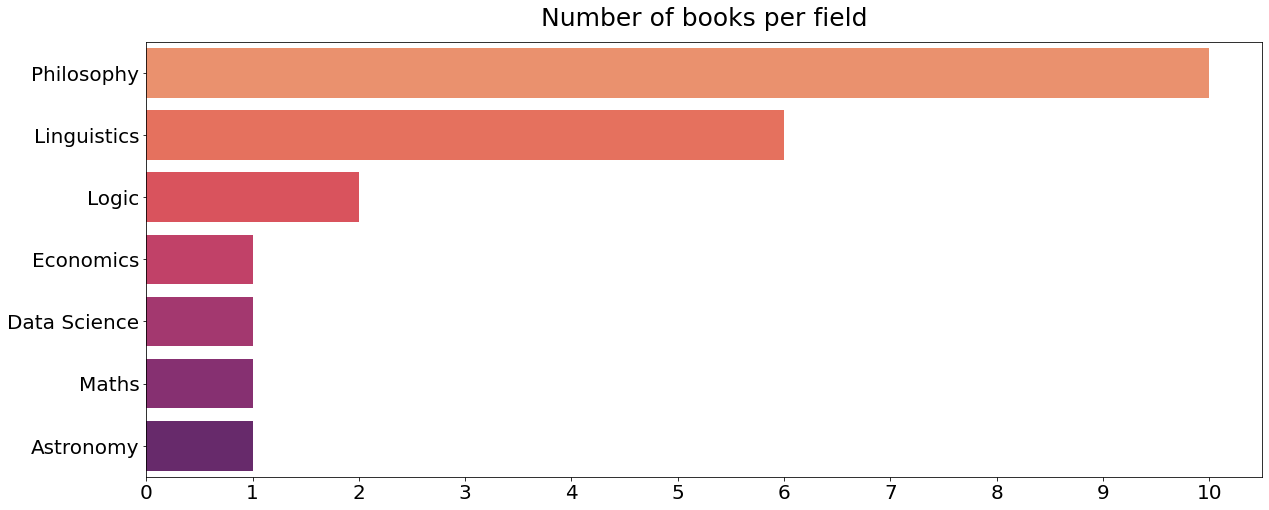

In [453]:
plt.figure(figsize=(20, 8))
types_of_books=sns.barplot(y=keys, x=vals, palette="flare", saturation=1)
types_of_books.set_title('Number of books per field', fontdict={'fontsize':25}, pad=16)
plt.xticks(np.arange(0, 11, 1.0))
plt.tick_params(axis='y', which='major', labelsize=20)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.show()

In [454]:
types_of_books.figure.savefig("../images/types_of_books.png", bbox_inches="tight")

### Visualization comparison metrics

In [373]:
comparison_metrics=[['Accuracy','General model',0.9906481704802732],
                    ['Accuracy','Philosophy model',0.992522026924281],
                    ['Precision','General model',0.7207505518763797],
                    ['Precision','Philosophy model',0.7841328413284133], 
                    ['Recall','General model', 0.23288159771754635],
                    ['Recall','Philosophy model',0.3715034965034965],
                    ['F1 score','General model',0.35202156334231804],
                    ['F1 score','Philosophy model',0.5041518386714117]]

In [374]:
comparison_metrics_df=pd.DataFrame(comparison_metrics, columns=['Metric','Model', 'Value'])

In [375]:
comparison_metrics_df

,Metric,Model,Value
0,Accuracy,General model,0.990648
1,Accuracy,Philosophy model,0.992522
2,Precision,General model,0.720751
3,Precision,Philosophy model,0.784133
4,Recall,General model,0.232882
5,Recall,Philosophy model,0.371503
6,F1 score,General model,0.352022
7,F1 score,Philosophy model,0.504152


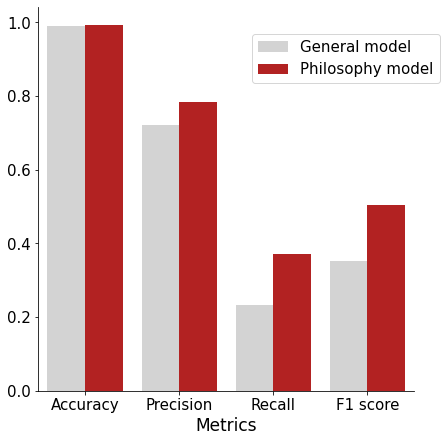

In [457]:
comparison_metrics_img = sns.catplot(
    data=comparison_metrics_df, kind="bar",
    x="Metric", y="Value", hue="Model", saturation=1,
    ci="sd", palette=['lightgrey','firebrick'], height=6, legend=False
)

plt.xlabel('Metrics',fontsize=17)
plt.ylabel('')
plt.tick_params(axis='both', labelsize=15)


plt.legend(loc = 2,fontsize=15, bbox_to_anchor = (0.55,0.95))

plt.savefig("../images/comparison_metrics_img.png", bbox_inches="tight")

# 3. Train and test the models

In [180]:
X = df_scaled.drop('target', axis= 1)
y = df_scaled.target

In [324]:
X1 = df_scaled_1.drop('target', axis= 1)
y1 = df_scaled_1.target

In [181]:
X_s = df_s_scaled.drop('target', axis= 1)
y_s = df_s_scaled.target

In [325]:
X_s1 = df_s_scaled_1.drop('target', axis= 1)
y_s1 = df_s_scaled_1.target

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

In [326]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3,
                                                    random_state=42, stratify=y1)

In [183]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.3,
                                                    random_state=42, stratify=y_s)

In [327]:
X_s_train1, X_s_test1, y_s_train1, y_s_test1 = train_test_split(X_s1, y_s1, test_size=0.3,
                                                    random_state=42, stratify=y_s1)

## Oversampling

In [328]:
smote = SMOTE(random_state=42)

In [ ]:
X_sm,y_sm=smote.fit_resample(X_train, y_train)

In [329]:
X_sm1,y_sm1=smote.fit_resample(X_train1, y_train1)

In [ ]:
X_sm_s,y_sm_s=smote.fit_resample(X_s_train, y_s_train)

In [330]:
X_sm_s1,y_sm_s1=smote.fit_resample(X_s_train1, y_s_train1)

In [ ]:
pickle.dump(X_sm, open('../models/X_sm.sav', 'wb'))
pickle.dump(y_sm, open('../models/y_sm.sav', 'wb'))

In [331]:
pickle.dump(X_sm1, open('../models/X_sm1.sav', 'wb'))
pickle.dump(y_sm1, open('../models/y_sm1.sav', 'wb'))

In [ ]:
pickle.dump(X_sm_s, open('../models/X_sm_s.sav', 'wb'))
pickle.dump(y_sm_s, open('../models/y_sm_s.sav', 'wb'))

In [332]:
pickle.dump(X_sm_s1, open('../models/X_sm_s1.sav', 'wb'))
pickle.dump(y_sm_s1, open('../models/y_sm_s1.sav', 'wb'))

In [184]:
X_sm = pickle.load(open('../models/X_sm.sav', 'rb'))
y_sm = pickle.load(open('../models/y_sm.sav', 'rb'))

In [333]:
X_sm1 = pickle.load(open('../models/X_sm1.sav', 'rb'))
y_sm1 = pickle.load(open('../models/y_sm1.sav', 'rb'))

In [10]:
X_sm_s = pickle.load(open('../models/X_sm_s.sav', 'rb'))
y_sm_s = pickle.load(open('../models/y_sm_s.sav', 'rb'))

In [334]:
X_sm_s1 = pickle.load(open('../models/X_sm_s1.sav', 'rb'))
y_sm_s1 = pickle.load(open('../models/y_sm_s1.sav', 'rb'))

In [ ]:
print('\nBefore OVER-sampling\n', y_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm.value_counts())

In [335]:
print('\nBefore OVER-sampling\n', y_train1.value_counts())
print('\nAfter OVER-sampling\n', y_sm1.value_counts())


Before OVER-sampling
 0.0    593265
1.0      6544
Name: target, dtype: int64

After OVER-sampling
 0.0    593265
1.0    593265
Name: target, dtype: int64


In [ ]:
print('\nBefore OVER-sampling\n', y_s_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm_s.value_counts())

In [336]:
print('\nBefore OVER-sampling\n', y_s_train1.value_counts())
print('\nAfter OVER-sampling\n', y_sm_s1.value_counts())


Before OVER-sampling
 0.0    258184
1.0      2671
Name: target, dtype: int64

After OVER-sampling
 0.0    258184
1.0    258184
Name: target, dtype: int64


## XGBoost classifier

### Big dataset

In [342]:
xgb_model=xgb.XGBClassifier(random_state=42)

In [ ]:
xgb_mod=xgb_model.fit(X_train,y_train.values.ravel()) 

In [355]:
xgb_mod1=xgb_model.fit(X_train1,y_train1.values.ravel()) 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:02:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
pickle.dump(xgb_mod, open('../models/xgb_mod.sav', 'wb'))

In [356]:
pickle.dump(xgb_mod1, open('../models/xgb_mod1.sav', 'wb'))

In [ ]:
xgb_mod = pickle.load(open('../models/xgb_mod.sav', 'rb'))

In [357]:
xgb_mod1 = pickle.load(open('../models/xgb_mod1.sav', 'rb'))

In [ ]:
y_pred_xgb = xgb_mod.predict(X_test)

In [358]:
y_pred_xgb1 = xgb_mod1.predict(X_test1)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_xgb)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_xgb)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_xgb)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_xgb)))

In [359]:
print('Accuracy Score : ' + str(accuracy_score(y_test1,y_pred_xgb1)))
print('Precision Score : ' + str(precision_score(y_test1,y_pred_xgb1)))
print('Recall Score : ' + str(recall_score(y_test1,y_pred_xgb1)))
print('F1 Score : ' + str(f1_score(y_test1,y_pred_xgb1)))

Accuracy Score : 0.9906481704802732
Precision Score : 0.7207505518763797
Recall Score : 0.23288159771754635
F1 Score : 0.35202156334231804


### Big dataset with SMOTE

In [12]:
xgb_mod_sm=xgb_model.fit(X_sm,y_sm.values.ravel()) 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:36:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [345]:
xgb_mod_sm1=xgb_model.fit(X_sm1,y_sm1.values.ravel()) 

[12:28:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
pickle.dump(xgb_mod_sm, open('../models/xgb_mod_sm.sav', 'wb'))

In [346]:
pickle.dump(xgb_mod_sm1, open('../models/xgb_mod_sm1.sav', 'wb'))

In [178]:
xgb_mod_sm = pickle.load(open('../models/xgb_mod_sm.sav', 'rb'))

In [347]:
xgb_mod_sm1 = pickle.load(open('../models/xgb_mod_sm1.sav', 'rb'))

In [15]:
y_pred_xgb_sm = xgb_mod_sm.predict(X_test)

In [348]:
y_pred_xgb_sm1 = xgb_mod_sm1.predict(X_test1)

In [16]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_xgb_sm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_xgb_sm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_xgb_sm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_xgb_sm)))

Accuracy Score : 0.9675914759863379
Precision Score : 0.19345535219079313
Recall Score : 0.6219686162624821
F1 Score : 0.29511803029021066


In [349]:
print('Accuracy Score : ' + str(accuracy_score(y_test1,y_pred_xgb_sm1)))
print('Precision Score : ' + str(precision_score(y_test1,y_pred_xgb_sm1)))
print('Recall Score : ' + str(recall_score(y_test1,y_pred_xgb_sm1)))
print('F1 Score : ' + str(f1_score(y_test1,y_pred_xgb_sm1)))

Accuracy Score : 0.967105211972209
Precision Score : 0.19053876478318002
Recall Score : 0.6205420827389444
F1 Score : 0.2915549597855228


### Small dataset

In [ ]:
xgb_mod_s=xgb_model.fit(X_s_train,y_s_train.values.ravel()) 

In [366]:
xgb_mod_s1=xgb_model.fit(X_s_train1,y_s_train1.values.ravel()) 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:08:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
pickle.dump(xgb_mod_s, open('../models/xgb_mod_s.sav', 'wb'))

In [362]:
pickle.dump(xgb_mod_s1, open('../models/xgb_mod_s1.sav', 'wb'))

In [ ]:
xgb_mod_s = pickle.load(open('../models/xgb_mod_s.sav', 'rb'))

In [363]:
xgb_mod_s1 = pickle.load(open('../models/xgb_mod_s1.sav', 'rb'))

In [ ]:
y_pred_xgb_s = xgb_mod_s.predict(X_s_test)

In [367]:
y_pred_xgb_s1 = xgb_mod_s1.predict(X_s_test1)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_xgb_s)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_xgb_s)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_xgb_s)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_xgb_s)))

In [368]:
print('Accuracy Score : ' + str(accuracy_score(y_s_test1,y_pred_xgb_s1)))
print('Precision Score : ' + str(precision_score(y_s_test1,y_pred_xgb_s1)))
print('Recall Score : ' + str(recall_score(y_s_test1,y_pred_xgb_s1)))
print('F1 Score : ' + str(f1_score(y_s_test1,y_pred_xgb_s1)))

Accuracy Score : 0.992522026924281
Precision Score : 0.7841328413284133
Recall Score : 0.3715034965034965
F1 Score : 0.5041518386714117


### Small dataset with SMOTE

In [17]:
xgb_mod_s_sm=xgb_mod.fit(X_sm_s,y_sm_s.values.ravel()) 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:41:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [350]:
xgb_mod_s_sm1=xgb_model.fit(X_sm_s1,y_sm_s1.values.ravel()) 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[12:32:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
pickle.dump(xgb_mod_s_sm, open('../models/xgb_mod_s_sm.sav', 'wb'))

In [351]:
pickle.dump(xgb_mod_s_sm1, open('../models/xgb_mod_s_sm1.sav', 'wb'))

In [177]:
xgb_mod_s_sm = pickle.load(open('../models/xgb_mod_s_sm.sav', 'rb'))

In [352]:
xgb_mod_s_sm1 = pickle.load(open('../models/xgb_mod_s_sm1.sav', 'rb'))

In [22]:
y_pred_xgb_s_sm = xgb_mod_s_sm.predict(X_s_test)

In [353]:
y_pred_xgb_s_sm1 = xgb_mod_s_sm1.predict(X_s_test1)

In [23]:
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_xgb_s_sm)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_xgb_s_sm)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_xgb_s_sm)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_xgb_s_sm)))

Accuracy Score : 0.9798559864036853
Precision Score : 0.2846034214618974
Recall Score : 0.6398601398601399
F1 Score : 0.39397201291711514


In [354]:
print('Accuracy Score : ' + str(accuracy_score(y_s_test1,y_pred_xgb_s_sm1)))
print('Precision Score : ' + str(precision_score(y_s_test1,y_pred_xgb_s_sm1)))
print('Recall Score : ' + str(recall_score(y_s_test1,y_pred_xgb_s_sm1)))
print('F1 Score : ' + str(f1_score(y_s_test1,y_pred_xgb_s_sm1)))

Accuracy Score : 0.9800348852810948
Precision Score : 0.28429817605075336
Recall Score : 0.6267482517482518
F1 Score : 0.3911620294599018


### Explainability

In [210]:
importance_xgb_sm = xgb_mod_sm.feature_importances_

list_of_importance_xgb_sm=zip(X.columns.tolist(), importance_xgb_sm.tolist())

print(list(list_of_importance_xgb_sm))

[('length', 0.05506904795765877), ('is_named_entity', 0.08164680749177933), ('is_named_author', 0.113590769469738), ('is_in_toc', 0.012414734810590744), ('freq', 0.1385580450296402), ('tfidf', 0.05461527034640312), ('importance', 0.00529780937358737), ('position_in_context', 0.009637911804020405), ('is_a_textbook_word', 0.012359146028757095), ('POS_ADJ', 0.007587687578052282), ('POS_ADP', 0.00747976778075099), ('POS_ADV', 0.046125978231430054), ('POS_AUX', 0.007945442572236061), ('POS_CCONJ', 0.0007129997247830033), ('POS_CHUNK', 0.3050233721733093), ('POS_DET', 0.0018702878151088953), ('POS_INTJ', 0.0019166000420227647), ('POS_NOUN', 0.04070378839969635), ('POS_NUM', 0.004307768307626247), ('POS_PART', 0.0), ('POS_PRON', 0.00814872793853283), ('POS_PROPN', 0.03570689260959625), ('POS_PUNCT', 0.0013896425953134894), ('POS_SCONJ', 0.01152265165001154), ('POS_SYM', 0.00037523373612202704), ('POS_VERB', 0.033463530242443085), ('POS_X', 0.0025300909765064716)]


In [ ]:
importance_xgb_s = xgb_mod_s.feature_importances_

list_of_importance_xgb_s=zip(X.columns.tolist(), importance_xgb_s.tolist())

print(list(list_of_importance_xgb_s))

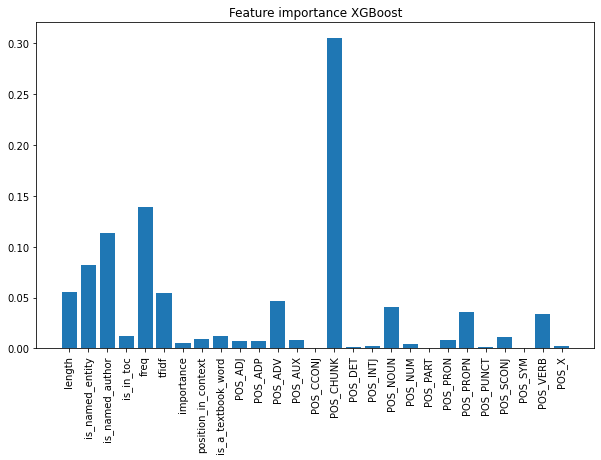

In [211]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_xgb_sm))]
labels = X_train.columns.tolist()
plt.bar(arr, importance_xgb_sm)
plt.title('Feature importance XGBoost')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

In [ ]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_xgb_s))]
labels = X_train.columns.tolist()
plt.bar(arr, importance_xgb_s)
plt.title('Feature importance XGBoost (small)')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

In [ ]:
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

In [ ]:
pickle.dump(shap_values, open('../models/shap_values.sav', 'wb'))

In [ ]:
pickle.dump(expected_value, open('../models/expected_value.sav', 'wb'))

In [ ]:
shap.summary_plot(shap_values, X,title="SHAP summary plot", show=False)
plt.savefig('../images/shap_summary.png')

In [185]:
explainer_xgb_sm = shap.TreeExplainer(xgb_mod_sm)
#shap_values_xgb_sm = explainer_xgb_sm.shap_values(X_sm)
#expected_value_xgb_sm = explainer_xgb_sm.expected_value
shap_values_xgb_sm_2=explainer_xgb_sm(X_sm)

In [186]:
pickle.dump(shap_values_xgb_sm_2, open('../models/shap_values_xgb_sm_2.sav', 'wb'))

In [316]:
shap_values_xgb_sm_2 = pickle.load(open('../models/shap_values_xgb_sm_2.sav', 'rb'))

In [317]:
shap_values_xgb_sm = pickle.load(open('../models/shap_values_RF_sm.sav', 'rb'))

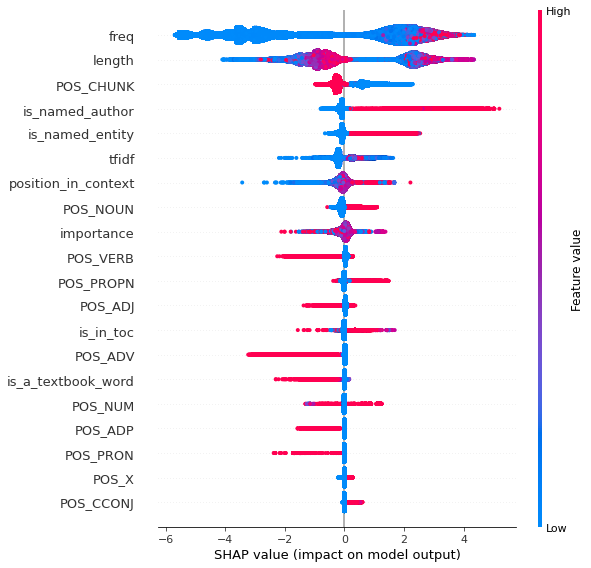

In [32]:
shap.summary_plot(shap_values_RF_sm,X_sm,title="SHAP summary plot RF", color=plt.get_cmap("cool"), show=False)
plt.savefig('../images/shap_summary_RF_sm.png')

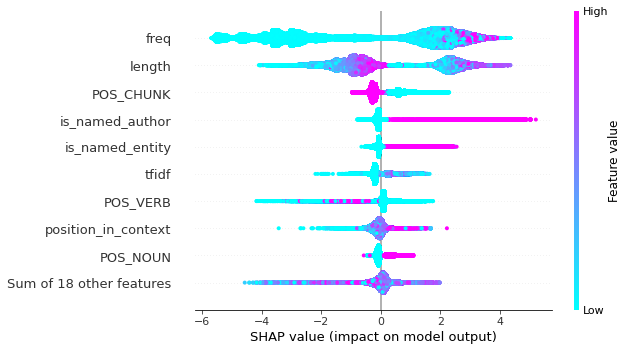

In [44]:
shap.plots.beeswarm(shap_values_RF_sm_2, color=plt.get_cmap("cool"), show=False)
plt.savefig('../images/shap_summary_RF_sm_3.png', bbox_inches="tight")

In [279]:
shap.plots.bar(shap_values_xgb_sm_2, max_display=8, show=False, plot_cmap=plt.get_cmap("cool"))
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
plt.rcParams['font.size'] = '12'


TypeError: bar() got an unexpected keyword argument 'plot_cmap'

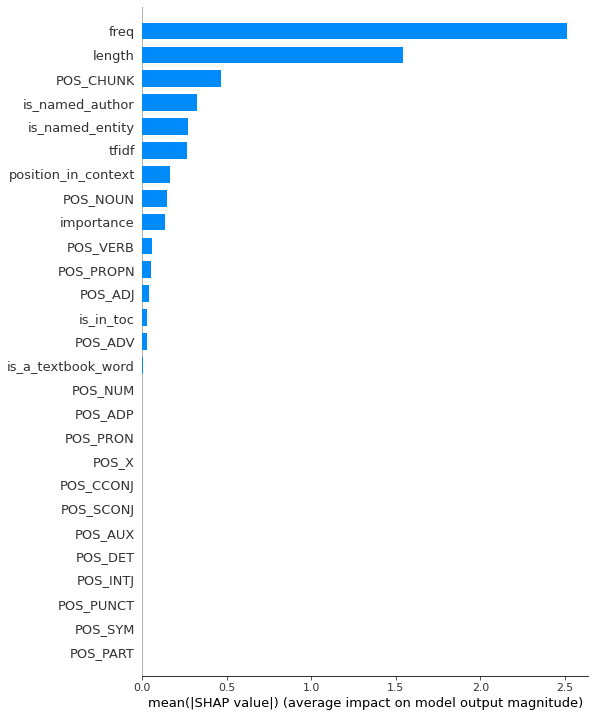

In [319]:
shap.summary_plot(shap_values_xgb_sm_2, X_sm, plot_type="bar", max_display=30,show=False)


In [369]:
explainer_xgb1 = shap.TreeExplainer(xgb_mod1)
#shap_values_xgb_sm = explainer_xgb_sm.shap_values(X_sm)
#expected_value_xgb_sm = explainer_xgb_sm.expected_value
shap_values_xgb1=explainer_xgb1(X1)

In [370]:
pickle.dump(shap_values_xgb1, open('../models/expected_value_xgb1.sav', 'wb'))

In [392]:
shap_values_xgb1 = pickle.load(open('../models/expected_value_xgb1.sav', 'rb'))

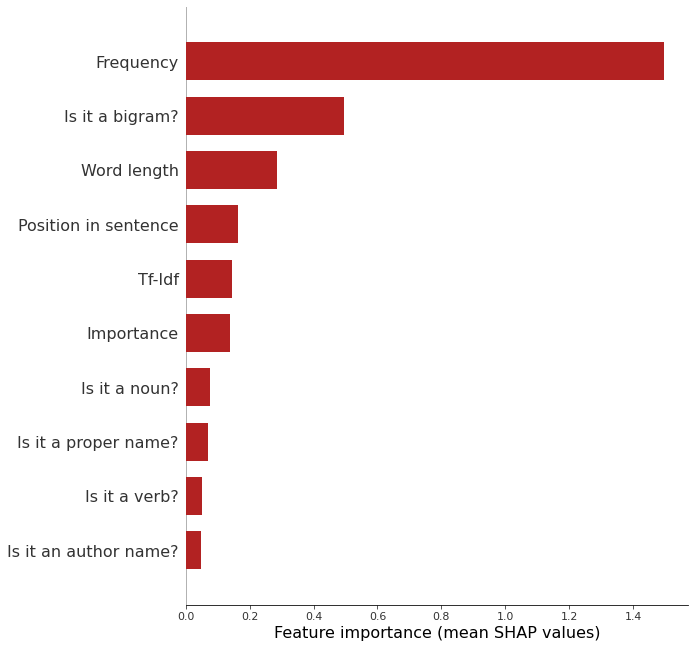

In [456]:
shap.summary_plot(shap_values_xgb1, X1, plot_type="bar", color='firebrick', max_display=10,show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
ax = plt.gca()
labels=['Is it an author name?','Is it a verb?','Is it a proper name?','Is it a noun?','Importance','Tf-Idf','Position in sentence','Word length','Is it a bigram?','Frequency']
ax.set_yticklabels(labels, fontsize=16)
ax.set_xlabel("Feature importance (mean SHAP values)", fontsize=16)

plt.savefig('../images/shap_summary_xgb1.png', bbox_inches="tight")